Here I'll be exploring the dataset based on the users tagged in certain posts. Working with this spin-off of the original dataset, see how easy it is to predict whether or not a certain tagged profile and thus inclusion in that post means it is more or less likely to receive more engagements. 

# In the block below, the remainder of this notebook are condensed into a single function. 

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('husl')
%matplotlib inline


def make_num(z):
    """
    Helper function for  the scraping tool. The result of a follower pull is 
    
    "35m followers", which this function will convert into 35 
    
    Parameters
    ----------
    
    z : str
        The follower count, given as "46m followers"
        
    Returns
    -------
    
    num : float
        The converted number, or 4.6e6. 
        
        Note this may occasionally return NaN, which means the account tagged was not actually found. 
    
    """
    
    import re
    from numpy import nan
    if type(z) == type(nan):
        return
    
    z = z.split()[0] #not the followers part
    z = z.replace(',','')
    num = re.split(r'[a-z]*',z)[0]
    
    order = "".join(re.findall(r'[a-z]*',z))
    if order == 'm':
        num = float(num) * 1e6
    if order == 'k':
        num = float(num) * 1e3
    else:
        num = float(num)
    
   # print("Followers = ", num)
    return num

def get_followers(z,driver):
    """
    Obtains follower count for profile in profile df. 
    
    Parameters
    ----------
    
    z : str
        The account name, done via an apply statement. 
        
    driver : WebDriver
        Selenium webdriver object, used to naviagate to the URL of each account, and then grab the corresponding
        followers. 
        
    Returns 
    -------
    
    followers : float
        The number of followers of that particular user. 

    """
    
    from time import sleep
    from random import randint
    z = z.replace('@','')
    url =  driver.get("https://www.instagram.com/"+ z + "/?hl=en")
    sleep(randint(1,3))
    hrefs_in_view = driver.find_elements_by_tag_name('a')
    
    #this gives the link that has the attached follower number. 
    for elem in hrefs_in_view:
        if elem.get_attribute('href') ==  "https://www.instagram.com/accounts/login/?next=%2F"+z+"%2Ffollowers%2F&source=followed_by_list": #'https://www.instagram.com/'+z+'/followers/':
            
            followers = make_num(elem.text)
            
            return followers
              
def load_tagged_profiles(instas):
    """
    
    Creates a dataset summarizing the instagram accounts tagged in the post. 
    The columns used are a temporary list, and this line will be finalized once it is. 
    
    
    Parameters
    ----------
    
    instas : df
        Dataframe of the instagram posts, their associated information + output of engagements
        
        
    Returns
    -------
    
    
    profile_df : df
    
        Dataframe of the profiles tagged in any or multiple posts. 
        
    """
    
    #use regular expression to obtain any time a name is used, find all
    import re
    posts = " ".join(instas['Description'].unique()).lower() #combine into a corpus, isolating each tag. 
    tagged_profiles = list( dict.fromkeys(re.findall('@[a-z_0-9]*',posts)) ) 
    d = []
    instas['Description'] = instas['Description'].str.lower()
    for account in tagged_profiles:
        posts_w_account = instas.loc[instas['Description'].str.contains(account)]
        max_eng = posts_w_account.Engagements.max()
        tot_eng = posts_w_account.Engagements.sum()
        n_posts = posts_w_account.Engagements.count()
        min_eng = posts_w_account.Engagements.min()
        avg_eng = posts_w_account.Engagements.mean()
        std_eng = posts_w_account.Engagements.std()
        d.append({'profile': account, 'max_eng': max_eng,'tot_eng' : tot_eng, 
                 'n_posts' : n_posts, 'min_eng' : min_eng, 'avg_eng' : avg_eng, 'std_eng' : std_eng})
   
    profile_df = pd.DataFrame(d)
    #but we're not done, can also establish how popular these accounts are, doing it based on follower count. 
    from selenium import webdriver
    driver = webdriver.Chrome('/Users/noahkasmanoff/Desktop/chromedriver') #open up chrome/spotify
    profile_df['followers']  = profile_df['profile'].apply(lambda z: get_followers(z,driver))
    driver.close()
    
    return profile_df

instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.dropna(inplace=True)


profile_df = load_tagged_profiles(instas)

/Users/noahkasmanoff/anaconda/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


# create a dataset of the profile, and use it to infer information to add back to the training set regarding that profile tagged in a post.

In [8]:
profile_df.sort_values('n_posts')

,avg_eng,max_eng,min_eng,n_posts,profile,std_eng,tot_eng,followers
762,607667.000000,607667,607667,1,@jeffteague,NaN,607667,124000.0
332,785658.000000,785658,785658,1,@tcraig3_,NaN,785658,41900.0
331,841205.000000,841205,841205,1,@spurscoyote,NaN,841205,72000.0
330,774437.000000,774437,774437,1,@jasonwilliams55,NaN,774437,234000.0
586,411664.000000,411664,411664,1,@kingrawle,NaN,411664,259000.0
587,411664.000000,411664,411664,1,@trey_duval,NaN,411664,NaN
327,742114.000000,742114,742114,1,@clydefrazier,NaN,742114,5391.0
324,408413.000000,408413,408413,1,@kgarea21,NaN,408413,227000.0
590,601293.000000,601293,601293,1,@cp3basketballacademy,NaN,601293,9963.0
319,706362.000000,706362,706362,1,@stickity13,NaN,706362,466000.0


So ignoring the faulty entries, the # of followers obeys some kind of distribution, which may be useful. 

In [19]:
profile_df = pd.read_csv('Business Analytics/tagged_profiles.csv')
profile_df.drop('std_eng',axis=1,inplace=True)

In [20]:
profile_df.dropna(inplace=True)

From https://www.adweek.com/digital/instagram-nba-players-teams-february-2017/, here's a list of stars and also most popular players. Perhaps this affects how many people view a post? 

# Now clusters? 

Will elbow method help illuminate which users are stars and which aren't?

In [21]:
profile_df.drop('tot_eng',axis=1,inplace=True)


In [24]:
profile_df

,avg_eng,max_eng,min_eng,n_posts,profile,followers
0,481730.119266,848228,198217,218,@raptors,2400000.0
1,541361.461538,848228,127816,13,@sergeibaka,881000.0
2,633178.625000,723934,502093,8,@normanpowell4,202000.0
3,601731.142857,696478,502093,7,@fredvanvleet,272000.0
4,587078.422222,854893,280401,45,@kyle_lowry7,1200000.0
5,569430.888889,706452,154757,9,@k_mid22,170000.0
6,487729.994898,810070,217833,196,@bucks,1800000.0
7,628804.266667,956368,253363,195,@giannis_an34,5000000.0
8,603939.379310,941443,304981,87,@lukadoncic,2600000.0
9,616215.732143,898784,287156,56,@traeyoung,1400000.0


In [25]:
profile_df['followers'] = np.log10(profile_df['followers']+1)
profile_df['n_posts'] = np.log10(profile_df['n_posts']+1)

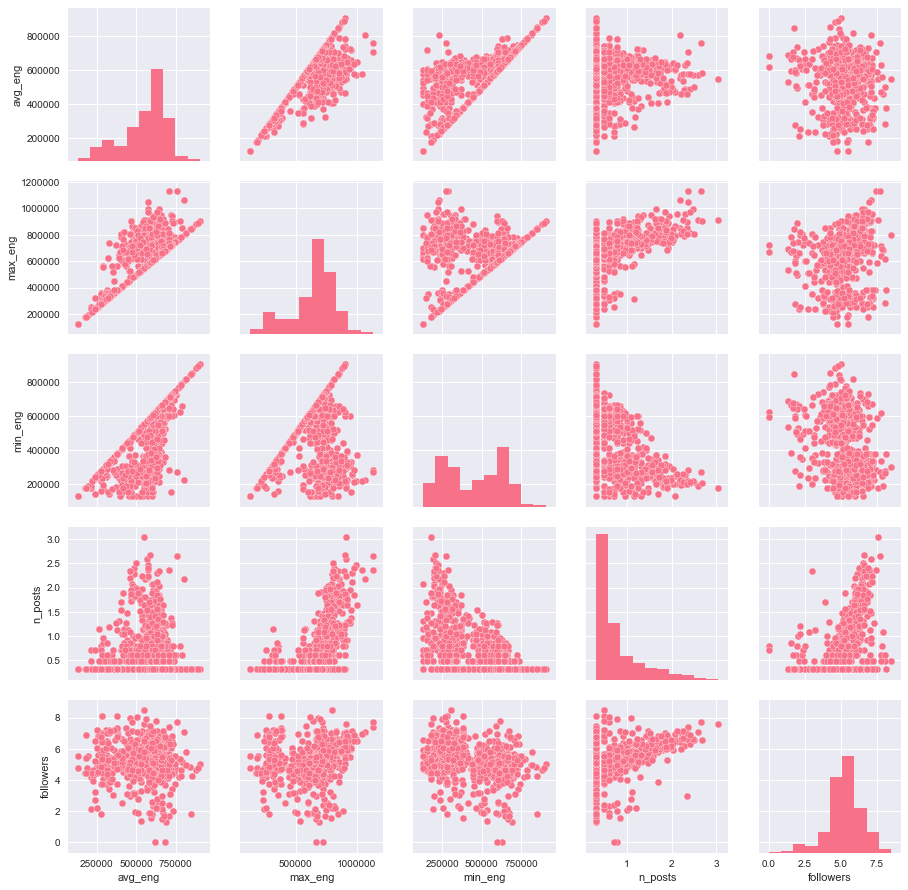

In [26]:
sns.pairplot(profile_df)

In [27]:
profile_df

,avg_eng,max_eng,min_eng,n_posts,profile,followers
0,481730.119266,848228,198217,2.340444,@raptors,6.380211
1,541361.461538,848228,127816,1.146128,@sergeibaka,5.944976
2,633178.625000,723934,502093,0.954243,@normanpowell4,5.305354
3,601731.142857,696478,502093,0.903090,@fredvanvleet,5.434571
4,587078.422222,854893,280401,1.662758,@kyle_lowry7,6.079182
5,569430.888889,706452,154757,1.000000,@k_mid22,5.230451
6,487729.994898,810070,217833,2.294466,@bucks,6.255273
7,628804.266667,956368,253363,2.292256,@giannis_an34,6.698970
8,603939.379310,941443,304981,1.944483,@lukadoncic,6.414974
9,616215.732143,898784,287156,1.755875,@traeyoung,6.146128


In [34]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

x = profile_df.drop('profile',axis=1).values #returns a numpy array #removes missing followers (broken accounts)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


In [41]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df)
    distortions.append(kmeanModel.inertia_)

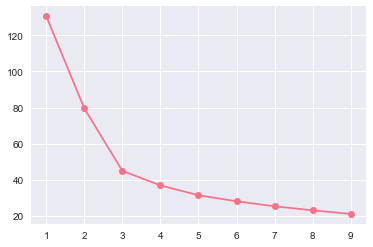

In [42]:
plt.plot(K,distortions,'o-')

In [43]:
kmeanModel = KMeans(n_clusters=3).fit(df)

In [44]:
kmeanModel.labels_

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 2, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 2, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2,
       0, 1, 1, 0, 0, 1, 0, 0, 2, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2, 2,
       2, 1, 2, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       2, 0, 0, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 2,

In [45]:
profile_df.dropna(subset=['followers'],inplace=True)
profile_df['tempCluster'] = kmeanModel.labels_

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


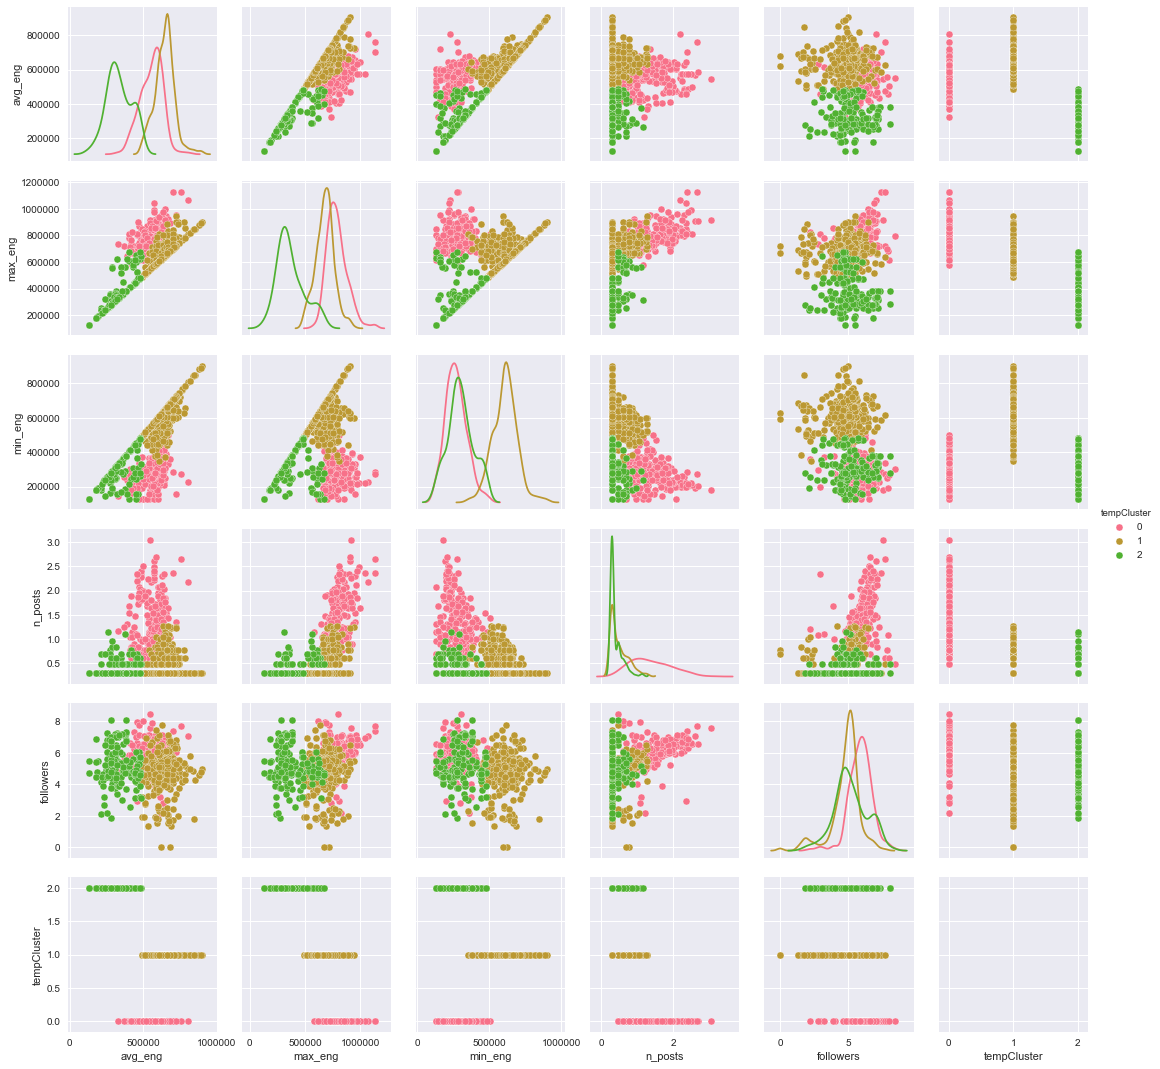

In [48]:
sns.pairplot(profile_df,hue='tempCluster',diag_kind='kde')

The end. 

The idea addition to the predictive model now is 


{everything else} + # of each respective cluster tagged in descritpion  ~= total num of engagements, 

where {everything else} includes information regarding the hashtags, time of post, previous number of followers, and more. 